In [7]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [80]:
print("Current working directory:", os.getcwd())
print("Working directory:", os.getcwd()) 
print("Base path contents:", os.listdir("."))  
#print("Images folder contents:", os.listdir("/Users/hiranmaidevarasetty/Downloads/sml dataset/Images"))  
dataset_path = '/Users/hiranmaidevarasetty/Downloads/sml dataset'

Current working directory: /Users/hiranmaidevarasetty/Downloads/sml dataset
Working directory: /Users/hiranmaidevarasetty/Downloads/sml dataset
Base path contents: ['captions.txt', 'Resnet-2.ipynb', 'Preprocessing.ipynb', '.DS_Store', 'Images', 'tmp.jpg', 'resnet_features.pkl', 'InceptionV3model.ipynb', 'Resnet1.ipynb', 'IV3(LSTM).ipynb', 'EncodedImageValidResNet.pkl', 'tokenizer.pkl', '.ipynb_checkpoints', 'EncodedImageTrainResNet.pkl', 'outputs']


In [9]:
images_path = os.path.join(dataset_path, "Images")  
captions_file = os.path.join(dataset_path, "captions.txt")  

In [10]:
example_image = os.path.join(images_path, "17273391_55cfc7d3d4.jpg")
image = Image.open(example_image)
image.show()

In [ ]:
captions_path = "/Users/hiranmaidevarasetty/Downloads/sml dataset/captions.txt"

image_captions = {}

with open(captions_path, 'r') as file:
    for line in file:
        if not line.strip():
            continue

        try:
            image_name, caption = line.strip().split(',', 1)  
            if image_name not in image_captions:
                image_captions[image_name] = []
            image_captions[image_name].append(caption)
        except ValueError:
            print(f"Skipping malformed line: {line.strip()}")

example_image = "1000268201_693b08cb0e.jpg"
if example_image in image_captions:
    print(f"Captions for {example_image}:")
    for i, caption in enumerate(image_captions[example_image]):
        print(f"{i+1}: {caption}")
else:
    print(f"No captions found for {example_image}.")


Captions for 1000268201_693b08cb0e.jpg:
1: A child in a pink dress is climbing up a set of stairs in an entry way .
2: A girl going into a wooden building .
3: A little girl climbing into a wooden playhouse .
4: A little girl climbing the stairs to her playhouse .
5: A little girl in a pink dress going into a wooden cabin .


In [ ]:
import pandas as pd

image_captions_df = pd.DataFrame([
    {"image": image, "caption": caption}
    for image, captions in image_captions.items()
    for caption in captions
])

print(image_captions_df.head())


                       image  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0                                            caption  
1  A child in a pink dress is climbing up a set o...  
2              A girl going into a wooden building .  
3   A little girl climbing into a wooden playhouse .  
4  A little girl climbing the stairs to her playh...  


In [13]:
def preprocess(caption):
    caption= caption.lower()
    caption = re.sub(r'[^\w\s]', '', caption)
    caption = re.sub('\s+', ' ', caption)
    caption= caption.strip()
    caption = '[start] ' + caption + ' [end]'
    return caption

In [14]:
image_captions_df['caption'] = image_captions_df['caption'].apply(preprocess)
print(image_captions_df.head())


                       image  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0                              [start] caption [end]  
1  [start] a child in a pink dress is climbing up...  
2  [start] a girl going into a wooden building [end]  
3  [start] a little girl climbing into a wooden p...  
4  [start] a little girl climbing the stairs to h...  


In [ ]:
print(image_captions_df.columns)
print(image_captions_df['image'].iloc[:5].to_list())


Index(['image', 'caption'], dtype='object')
['image', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg']


In [ ]:
print(image_captions_df['image'].head())
image_captions_df = image_captions_df[image_captions_df['image'] != "image"]


0                        image
1    1000268201_693b08cb0e.jpg
2    1000268201_693b08cb0e.jpg
3    1000268201_693b08cb0e.jpg
4    1000268201_693b08cb0e.jpg
Name: image, dtype: object


In [ ]:
base_path = "/Users/hiranmaidevarasetty/Downloads/sml dataset/Images/"

image_captions_df['image'] = image_captions_df['image'].apply(
    lambda x: os.path.join(base_path, x)
)

print(image_captions_df['image'].head())

1    /Users/hiranmaidevarasetty/Downloads/sml datas...
2    /Users/hiranmaidevarasetty/Downloads/sml datas...
3    /Users/hiranmaidevarasetty/Downloads/sml datas...
4    /Users/hiranmaidevarasetty/Downloads/sml datas...
5    /Users/hiranmaidevarasetty/Downloads/sml datas...
Name: image, dtype: object


In [ ]:
first_image_path = image_captions_df['image'].iloc[0]
if os.path.exists(first_image_path):
    print(f"File exists: {first_image_path}")
else:
    print(f"File not found: {first_image_path}")

File exists: /Users/hiranmaidevarasetty/Downloads/sml dataset/Images/1000268201_693b08cb0e.jpg


In [19]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [20]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(image_captions_df['caption'])

In [21]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [22]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_captions_df['image'], image_captions_df['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [23]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(32360, 32360, 8095, 8095)

In [24]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [27]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [28]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [29]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [30]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/Users/hiranmaidevarasetty/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 40, 512])

In [31]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [32]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [33]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [34]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [35]:
history = caption_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 6179s 6s/step - acc: 0.1600 - loss: 5.4148 - val_acc: 0.2407 - val_loss: 4.5944
Epoch 2/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 6422s 6s/step - acc: 0.2390 - loss: 4.5096 - val_acc: 0.2467 - val_loss: 4.4493
Epoch 3/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 5990s 6s/step - acc: 0.2426 - loss: 4.3695 - val_acc: 0.2467 - val_loss: 4.3945
Epoch 4/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 10590s 10s/step - acc: 0.2426 - loss: 4.3650 - val_acc: 0.2501 - val_loss: 4.3813
Epoch 5/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3398s 3s/step - acc: 0.2483 - loss: 4.2599 - val_acc: 0.2550 - val_loss: 4.3236


In [54]:
idx2word(2).numpy().decode('utf-8')

'a'

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def generate_caption(img_path):
    img = load_image_from_path(img_path)  
    img = tf.expand_dims(img, axis=0)   
    img_embed = caption_model.cnn_model(img)  
    img_encoded = caption_model.encoder(img_embed, training=False)  

    y_inp = '[start]'
    for i in range(MAX_LENGTH - 1):
        tokenized = tokenizer([y_inp])[:, :-1] 
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask
        )  

        pred_idx = np.argmax(pred[0, i, :])  
        pred_word = idx2word(pred_idx).numpy().decode('utf-8') 
        if pred_word == '[end]': 
            break

        y_inp += ' ' + pred_word  

    y_inp = y_inp.replace('[start] ', '')  
    return y_inp

Predicted Caption: a man is running on a red shirt is running



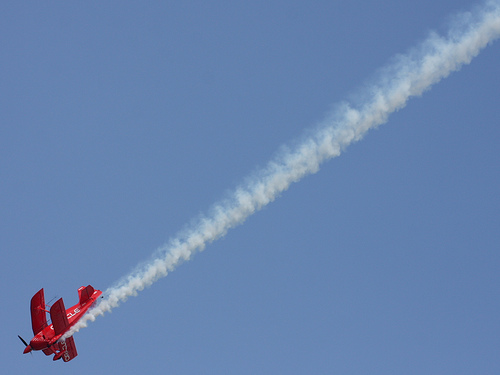

In [60]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [61]:
! pip install nltk


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [62]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize


In [63]:
def calculate_bleu(pred_caption, reference_captions):
    # Tokenize the predicted caption
    pred_tokens = word_tokenize(pred_caption.lower())
    # Tokenize the reference captions
    reference_tokens = [word_tokenize(ref.lower()) for ref in reference_captions]
    # Calculate BLEU score with smoothing
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, pred_tokens, smoothing_function=smoothing)
    return bleu_score


In [81]:
ground_truth_captions = {}

captions_file = "/Users/hiranmaidevarasetty/Downloads/sml dataset/captions.txt"

with open(captions_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:  
            print("Skipping empty line.")
            continue
        parts = line.split(",")  
        if len(parts) != 2:  
            print(f"Skipping malformed line: {line}")
            continue
        img_name, caption = parts
        if img_name not in ground_truth_captions:
            ground_truth_captions[img_name] = []
        ground_truth_captions[img_name].append(caption)

#print("Ground truth captions loaded:", ground_truth_captions)


Skipping malformed line: 1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red ball next to it ."
Skipping malformed line: 1012212859_01547e3f17.jpg,"Dog with orange ball at feet , stands on shore shaking off water"
Skipping malformed line: 1022454332_6af2c1449a.jpg,"Two people are at the edge of a lake , facing the water and the city skyline ."
Skipping malformed line: 1022454428_b6b660a67b.jpg,"A couple and an infant , being held by the male , sitting next to a pond with a near by stroller ."
Skipping malformed line: 103106960_e8a41d64f8.jpg,"Hockey goalie boy in red jacket crouches by goal , with stick ."
Skipping malformed line: 103205630_682ca7285b.jpg,"Two men , standing on an ice , looking into something covered with a blue tarp ."
Skipping malformed line: 1042590306_95dea0916c.jpg,"Asian man and blond woman holding hands outdoors , man in background watches ."
Skipping malformed line: 105342180_4d4a40b47f.jpg,"A girl paddling down a large river , as seen from 

In [78]:
print("Sample ground truth captions:", list(ground_truth_captions.items())[:5])


Sample ground truth captions: [('image', ['caption']), ('1000268201_693b08cb0e.jpg', ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']), ('1001773457_577c3a7d70.jpg', ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']), ('1002674143_1b742ab4b8.jpg', ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white

In [ ]:
import os

total_bleu_score = 0
n = len(val_imgs)  

for img_path in val_imgs:
    img_name = os.path.basename(img_path)  
    if img_name not in ground_truth_captions:
        print(f"Ground truth captions not found for: {img_name}")
        continue  
    pred_caption = generate_caption(img_path)  
    reference_captions = ground_truth_captions[img_name] 

    bleu_score = calculate_bleu(pred_caption, reference_captions)
    total_bleu_score += bleu_score

    print(f"Image: {img_path}")
    print(f"Predicted Caption: {pred_caption}")
    print(f"BLEU Score: {bleu_score}")
    print()

if n > 0:
    average_bleu_score = total_bleu_score / n
    print(f"Average BLEU Score: {average_bleu_score}")
else:
    print("No BLEU scores were calculated. Ensure ground truth captions are available.")


Image: /Users/hiranmaidevarasetty/Downloads/sml dataset/Images/2432709509_2a4d0c833f.jpg
Predicted Caption: a man is is running in a red shirt in a red shirt in a red shirt in a red shirt is is is is running in a red shirt in a man is running in a red shirt
BLEU Score: 0.012615497851482763

Image: /Users/hiranmaidevarasetty/Downloads/sml dataset/Images/2432709509_2a4d0c833f.jpg
Predicted Caption: a man is is running in a red shirt in a red shirt in a red shirt in a red shirt is is is is running in a red shirt in a man is running in a red shirt
BLEU Score: 0.012615497851482763

Image: /Users/hiranmaidevarasetty/Downloads/sml dataset/Images/2432709509_2a4d0c833f.jpg
Predicted Caption: a man is is running in a red shirt in a red shirt in a red shirt in a red shirt is is is is running in a red shirt in a man is running in a red shirt
BLEU Score: 0.012615497851482763

Image: /Users/hiranmaidevarasetty/Downloads/sml dataset/Images/2432709509_2a4d0c833f.jpg
Predicted Caption: a man is is runn

In [82]:
print(f"Average BLEU Score: {average_bleu_score}")

Average BLEU Score: 0.0565172745112673
